# 1. Data Cleaning 

In [289]:
# installing
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [290]:
bitmex_price = pd.read_csv('bitmex_prices .csv')

### Checking missing values

In [291]:
bitmex_price.isnull().sum()

date      0
xbtusd    0
dtype: int64

**Observation** <br>
No missing values,data is already cleaned. but we want to make sure
1. datetypes is stored appropriately
2. The data is in correct order

In [292]:
bitmex_price.head()

,date,xbtusd
0,2019-04-13 10:55:00,5053.25
1,2019-04-13 10:56:00,5053.25
2,2019-04-13 10:57:00,5053.25
3,2019-04-13 10:58:00,5052.25
4,2019-04-13 10:59:00,5049.25


In [293]:
bitmex_price.dtypes

date       object
xbtusd    float64
dtype: object

**currently the date column is object data type, converting it to datetime to allow more manipulation on data**

In [294]:
bitmex_price['date'] = pd.to_datetime(bitmex_price['date'])
bitmex_price.dtypes

date      datetime64[ns]
xbtusd           float64
dtype: object

In [295]:
bitmex_price['date'][1] - bitmex_price['date'][0]

Timedelta('0 days 00:01:00')

### Making sure the date was correctly sorted 

In [296]:
temp = bitmex_price.sort_values(by='date')

In [297]:
(temp['date'] == bitmex_price['date']).sum() == len(bitmex_price)

True

the data is in correct order

# 2. Data Analysis & Visualization

In [298]:
bitmex_price.describe()

,xbtusd
count,121922.000000
mean,7861.513337
std,2125.928309
min,4958.250000
25%,5679.750000
50%,7938.750000
75%,8873.250000
max,13888.250000


## The Prices from beginning  to the end

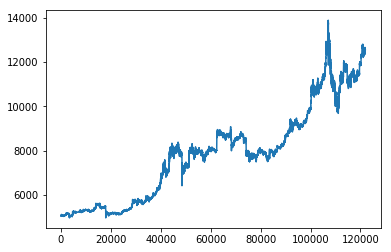

In [299]:
plt.plot(bitmex_price['xbtusd'])

## The Prices of last 30 minutes

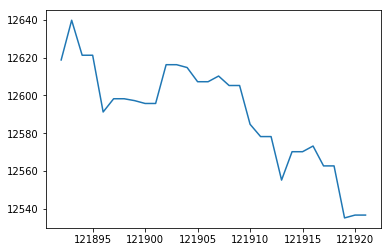

In [300]:
plt.plot(bitmex_price['xbtusd'][-30:])

In [301]:
def to_hour(df, agg=np.mean):
    df = df.copy()
    counter = 0
    minunte_prices = []
    hour_prices = []
    for x in df['xbtusd']:
        minunte_prices.append(x)
        if len(minunte_prices) == 60:
            hour_prices.append(agg(minunte_prices))
            minunte_prices = []
    hour_prices.append(agg(minunte_prices))
    return pd.Series(hour_prices)

hour_avg_prices = to_hour(bitmex_price, np.mean)
hour_max_prices = to_hour(bitmex_price, np.max)
hour_min_prices = to_hour(bitmex_price, np.min)

## The Average  Prices by Hour

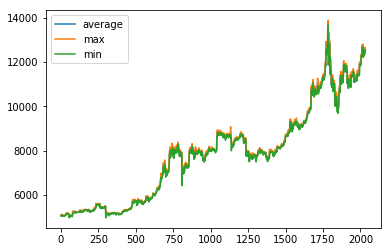

In [302]:
plt.plot(hour_avg_prices)
plt.plot(hour_max_prices)
plt.plot(hour_min_prices)

plt.legend(['average', 'max', 'min'], loc='upper left')

### last 24 hours

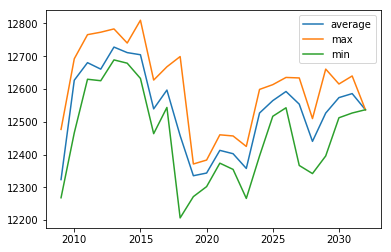

In [303]:
plt.plot(hour_avg_prices[-24:])
plt.plot(hour_max_prices[-24:])
plt.plot(hour_min_prices[-24:])

plt.legend(['average', 'max', 'min'], loc='upper right')

In [304]:
def to_day(df, agg=np.mean):
    hours = to_hour(df, agg)
    hour_prices = []
    day_prices = []
    for hour in hours:
        hour_prices.append(hour)
        if len(hour_prices) == 24:
            day_prices.append(agg(hour_prices))
            hour_prices = []
    day_prices.append(agg(hour_prices))
    return pd.Series(day_prices)

day_avg = to_day(bitmex_price, np.mean)
day_max = to_day(bitmex_price, np.max)
day_min = to_day(bitmex_price, np.min)

## Prices By Days

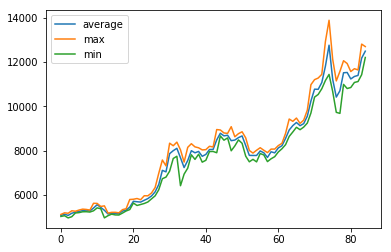

In [305]:
plt.plot(day_avg)
plt.plot(day_max)
plt.plot(day_min)

plt.legend(['average', 'max', 'min'], loc='upper left')

### last 7 days

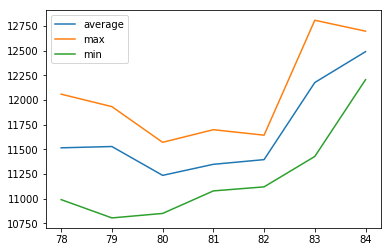

In [306]:
plt.plot(day_avg[-7:])
plt.plot(day_max[-7:])
plt.plot(day_min[-7:])

plt.legend(['average', 'max', 'min'], loc='upper left')

# 3. Feature Engineering

**Set Target Variable** <br>
We want to predict the next minute price will rise or not. Therefore, if current minutes' price is higher than the last minute, it is 1, otherwise it is 0

In [307]:
y = bitmex_price['xbtusd'].shift(-1)
bitmex_price['target'] = y
bitmex_price.drop(bitmex_price.index[0] , inplace=True)
bitmex_price.drop(bitmex_price.index[-1] , inplace=True)
bitmex_price.head()

,date,xbtusd,target
1,2019-04-13 10:56:00,5053.25,5053.25
2,2019-04-13 10:57:00,5053.25,5052.25
3,2019-04-13 10:58:00,5052.25,5049.25
4,2019-04-13 10:59:00,5049.25,5047.25
5,2019-04-13 11:00:00,5047.25,5051.25


### Adding Custome Features 

we will be adding following list of features to see if can help us classify better
1. change from 1 minute ago
2. change from 3 minute ago 
3. change from 5 minute ago 
4. change from 10 minute ago
5. difference from average of last 5 mins
6. difference from average of last 10 mins
7. difference from average of last 60 mins

In [308]:
bitmex_price['1mins_ago'] =  bitmex_price['xbtusd'] - bitmex_price['xbtusd'].shift(1) 
bitmex_price['3mins_ago'] =  bitmex_price['xbtusd'] - bitmex_price['xbtusd'].shift(3) 
bitmex_price['5mins_ago'] = bitmex_price['xbtusd'] - bitmex_price['xbtusd'].shift(5)
bitmex_price['10mins_ago'] = bitmex_price['xbtusd'] - bitmex_price['xbtusd'].shift(10)

In [309]:
def every_x_min_avg(df, x):
    sum_series = df['xbtusd'].copy()
    for i in range(x-1):
        sum_series += df['xbtusd'].shift(i)
    return sum_series / x

bitmex_price['5mins_avg'] = every_x_min_avg(bitmex_price, 5)
bitmex_price['10mins_avg'] = every_x_min_avg(bitmex_price, 10)
bitmex_price['60mins_avg'] = every_x_min_avg(bitmex_price, 60)
bitmex_price.tail()

,date,xbtusd,target,1mins_ago,3mins_ago,5mins_ago,10mins_ago,5mins_avg,10mins_avg,60mins_avg
121916,2019-07-09 23:46:00,12573.25,12562.75,3.0,18.0,-5.0,-34.0,12568.45,12579.40,12585.975000
121917,2019-07-09 23:47:00,12562.75,12562.75,-10.5,-7.5,-15.5,-47.5,12567.85,12574.10,12586.116667
121918,2019-07-09 23:48:00,12562.75,12535.25,0.0,-7.5,7.5,-42.5,12566.35,12569.85,12586.425000
121919,2019-07-09 23:49:00,12535.25,12536.75,-27.5,-38.0,-35.0,-70.0,12553.85,12562.15,12586.108333
121920,2019-07-09 23:50:00,12536.75,12536.75,1.5,-26.0,-33.5,-48.0,12546.85,12558.15,12586.300000


In [310]:
bitmex_price['diff_5avg'] = bitmex_price['xbtusd'] - bitmex_price['5mins_avg']
bitmex_price['diff_10avg'] = bitmex_price['xbtusd'] - bitmex_price['10mins_avg']
bitmex_price['diff_60avg'] = bitmex_price['xbtusd'] - bitmex_price['60mins_avg']
bitmex_price.tail()

,date,xbtusd,target,1mins_ago,3mins_ago,5mins_ago,10mins_ago,5mins_avg,10mins_avg,60mins_avg,diff_5avg,diff_10avg,diff_60avg
121916,2019-07-09 23:46:00,12573.25,12562.75,3.0,18.0,-5.0,-34.0,12568.45,12579.40,12585.975000,4.8,-6.15,-12.725000
121917,2019-07-09 23:47:00,12562.75,12562.75,-10.5,-7.5,-15.5,-47.5,12567.85,12574.10,12586.116667,-5.1,-11.35,-23.366667
121918,2019-07-09 23:48:00,12562.75,12535.25,0.0,-7.5,7.5,-42.5,12566.35,12569.85,12586.425000,-3.6,-7.10,-23.675000
121919,2019-07-09 23:49:00,12535.25,12536.75,-27.5,-38.0,-35.0,-70.0,12553.85,12562.15,12586.108333,-18.6,-26.90,-50.858333
121920,2019-07-09 23:50:00,12536.75,12536.75,1.5,-26.0,-33.5,-48.0,12546.85,12558.15,12586.300000,-10.1,-21.40,-49.550000


In [311]:
bitmex_price.drop(columns=['5mins_avg', '10mins_avg', '60mins_avg'], inplace=True)
bitmex_price.head()

,date,xbtusd,target,1mins_ago,3mins_ago,5mins_ago,10mins_ago,diff_5avg,diff_10avg,diff_60avg
1,2019-04-13 10:56:00,5053.25,5053.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-13 10:57:00,5053.25,5052.25,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-04-13 10:58:00,5052.25,5049.25,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-13 10:59:00,5049.25,5047.25,-3.0,-4.0,NaN,NaN,-2.2,NaN,NaN
5,2019-04-13 11:00:00,5047.25,5051.25,-2.0,-6.0,NaN,NaN,-2.6,NaN,NaN


In [312]:
bitmex_price.drop(bitmex_price.index[0:60], inplace=True)
bitmex_price.reset_index(drop=True, inplace=True)
bitmex_price.head(10)

,date,xbtusd,target,1mins_ago,3mins_ago,5mins_ago,10mins_ago,diff_5avg,diff_10avg,diff_60avg
0,2019-04-13 11:56:00,5057.50,5058.75,0.75,3.25,3.25,0.75,1.45,2.150,0.341667
1,2019-04-13 11:57:00,5058.75,5059.75,1.25,4.50,4.50,3.00,1.55,2.975,1.462500
2,2019-04-13 11:58:00,5059.75,5061.25,1.00,3.00,5.50,4.00,1.25,3.375,2.270833
3,2019-04-13 11:59:00,5061.25,5061.25,1.50,3.75,7.00,6.50,1.55,4.025,3.512500
4,2019-04-13 12:00:00,5061.25,5060.25,0.00,2.50,4.50,7.00,0.80,3.325,3.345833
5,2019-04-13 12:01:00,5060.25,5058.75,-1.00,0.50,2.75,6.00,-0.30,1.825,2.270833
6,2019-04-13 12:02:00,5058.75,5059.25,-1.50,-2.50,0.00,4.50,-1.30,0.025,0.729167
7,2019-04-13 12:03:00,5059.25,5059.50,0.50,-2.00,-0.50,5.00,-0.50,-0.025,1.145833
8,2019-04-13 12:04:00,5059.50,5059.75,0.25,-0.75,-1.75,5.25,0.05,-0.075,1.320833
9,2019-04-13 12:05:00,5059.75,5060.75,0.25,1.00,-1.50,3.00,0.35,-0.075,1.508333


In [313]:
bitmex_price.isnull().sum()

date          0
xbtusd        0
target        0
1mins_ago     0
3mins_ago     0
5mins_ago     0
10mins_ago    0
diff_5avg     0
diff_10avg    0
diff_60avg    0
dtype: int64

In [314]:
from sklearn.model_selection import train_test_split
y = bitmex_price.target
bitmex_price.drop(columns=['target', 'date'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(bitmex_price, y, test_size=0.20, shuffle=False)

In [315]:
x_train.head()

,xbtusd,1mins_ago,3mins_ago,5mins_ago,10mins_ago,diff_5avg,diff_10avg,diff_60avg
0,5057.50,0.75,3.25,3.25,0.75,1.45,2.150,0.341667
1,5058.75,1.25,4.50,4.50,3.00,1.55,2.975,1.462500
2,5059.75,1.00,3.00,5.50,4.00,1.25,3.375,2.270833
3,5061.25,1.50,3.75,7.00,6.50,1.55,4.025,3.512500
4,5061.25,0.00,2.50,4.50,7.00,0.80,3.325,3.345833


In [316]:
y_train.head()

0    5058.75
1    5059.75
2    5061.25
3    5061.25
4    5060.25
Name: target, dtype: float64

In [319]:
x_train.to_csv('x_train.csv', index=False, header=True)

x_test.to_csv('x_test.csv', index=False, header=True)

y_train.to_csv('y_train.csv', index=False, header=True)

y_test.to_csv('y_test.csv', index=False, header=True)